# Projeto 1: Classificação binária brest cancer

## Etapa 1: Importação das bibliotecas

In [47]:
#load database
import pandas as pd
#split datbase in train and test
from sklearn.model_selection import train_test_split
#support for multidimentional arrays and matrices + mathematical funtions
import numpy as np
#high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
#machine learning algorithms
from sklearn.metrics import confusion_matrix, accuracy_score

In [48]:
import torch
torch.__version__
#!pip install torch==1.4.0

'1.13.1+cpu'

In [49]:
import torch.nn as nn

## Etapa 2: Base de dados

In [50]:
#defining seeds, ensure reproducibility
np.random.seed(123)
torch.manual_seed(123)

In [51]:
previsores = pd.read_csv('./databases/entradas_breast.csv')
classe = pd.read_csv('./databases/saidas_breast.csv')

In [52]:
previsores.shape

(569, 30)

In [53]:
#5 first rows
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [54]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [55]:
np.unique(classe)

array([0, 1], dtype=int64)

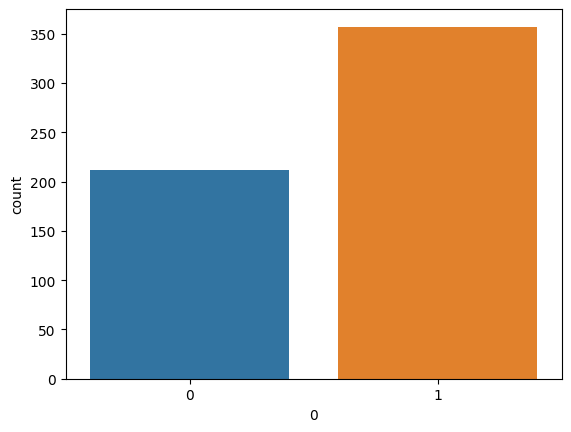

In [93]:
sns.countplot(classe, x="0");

In [57]:
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores,
                                                                                              classe,
                                                                                              test_size = 0.25)

In [58]:
previsores_treinamento.shape

(426, 30)

In [59]:
classe_treinamento.shape

(426, 1)

In [60]:
previsores_teste.shape

(143, 30)

In [61]:
classe_teste.shape

(143, 1)

## Etapa 3: Transformação dos dados para tensores


In [62]:
type(previsores_treinamento)

pandas.core.frame.DataFrame

In [63]:
type(np.array(previsores_treinamento))

numpy.ndarray

In [64]:
#transform dataframe into numpy array
previsores_treinamento = torch.tensor(np.array(previsores_treinamento), dtype=torch.float)
#transform numpy array into tensor
classe_treinamento = torch.tensor(np.array(classe_treinamento), dtype = torch.float)

In [65]:
type(previsores_treinamento)

torch.Tensor

In [66]:
type(classe_treinamento)

torch.Tensor

In [67]:
dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)

In [68]:
type(dataset)

torch.utils.data.dataset.TensorDataset

In [69]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
#10 in 10 to update weights

## Etapa 4: Construção do modelo

In [70]:
# 30 -> 16 -> 16 -> 1
# first layer 30 -> same as the number of features
# 2 hidden layers with 16 neurons
# exit layer 1 neuron in this case since it is a binary classification
# (entradas + saida) / 2 = (30 + 1) / 2 = 16
# nn -> neural network
# sequential -> each layer is defined in a sequential order
classificador = nn.Sequential(
    nn.Linear(in_features=30, out_features=16), #linear means all the neurons from the first layer connet to all the neurons from the first hidden layer 16
    nn.ReLU(), #relu function will be aplied to the 16 neurons
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid() #activation function, sgmoid for a probabilit between 0 and 1
)

In [71]:
#neural network structure
classificador.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>

In [72]:
#defining the loss function
criterion = nn.BCELoss()

In [73]:
#defining the optimizer
#lr - learning rate
#weight decay - after x epochs lowers learning rate, helps getting clodser to the gradient
#the lr will be multiplied by the weight decay that will help the algorithm react a global minimum
optimizer = torch.optim.Adam(classificador.parameters(), lr=0.001, weight_decay=0.0001)

## Etapa 5: Treinamento do modelo

In [74]:
#range(100) the weigths will be updated 100 times
#426 entries, batch size 10, about 43 weight updates in each epoch
for epoch in range(100):
  #variable accumulate error
  running_loss = 0.

  for data in train_loader:
    inputs, labels = data
    #print(inputs)
    #print('-----')
    #print(labels)
    optimizer.zero_grad()

    outputs = classificador(inputs) # classificador.forward(inputs)
    #print(outputs)
    #loss -> compare the outputs with the labels
    loss = criterion(outputs, labels)
    #print(loss)
    #backpropagation
    loss.backward()
    #adam optimizing weights
    optimizer.step()

    running_loss += loss.item()
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))

Época   1: perda 10.78337
Época   2: perda 2.84859
Época   3: perda 1.67479
Época   4: perda 1.11414
Época   5: perda 0.63996
Época   6: perda 0.63753
Época   7: perda 0.58066
Época   8: perda 0.55460
Época   9: perda 0.55617
Época  10: perda 0.53322
Época  11: perda 0.55797
Época  12: perda 0.53816
Época  13: perda 0.52938
Época  14: perda 0.33227
Época  15: perda 0.51360
Época  16: perda 0.35532
Época  17: perda 0.49602
Época  18: perda 0.33208
Época  19: perda 0.29349
Época  20: perda 0.25046
Época  21: perda 0.29527
Época  22: perda 0.49888
Época  23: perda 0.47241
Época  24: perda 0.45883
Época  25: perda 0.27544
Época  26: perda 0.23399
Época  27: perda 0.26373
Época  28: perda 0.24136
Época  29: perda 0.28275
Época  30: perda 0.22670
Época  31: perda 0.19300
Época  32: perda 0.22247
Época  33: perda 0.20294
Época  34: perda 0.20900
Época  35: perda 0.20250
Época  36: perda 0.20269
Época  37: perda 0.18850
Época  38: perda 0.22386
Época  39: perda 0.22918
Época  40: perda 0.20068

## Etapa 6: Visualização dos pesos

In [75]:
# 30 -> 16 -> 16 -> 1
params = list(classificador.parameters())

In [76]:
params

[Parameter containing:
 tensor([[-6.9537e-02, -7.6251e-02, -1.7509e-01,  5.4204e-02, -1.5442e-01,
           1.0065e-01, -1.3578e-01, -1.2356e-01, -2.2725e-01,  1.9374e-01,
          -3.4267e-02,  5.8904e-02, -1.2563e-01, -8.7217e-02, -3.5901e-04,
          -2.2019e-01, -3.9123e-01, -1.2445e-02,  1.3856e-01,  2.4448e-03,
           1.4020e-01, -4.8890e-02, -3.3449e-02,  1.4495e-01,  4.9342e-01,
           1.2753e-01, -1.8688e-01,  3.9847e-02,  2.8978e-01,  4.1387e-02],
         [ 1.9539e-01,  2.0192e-01,  2.8234e-01,  9.1706e-02, -1.3019e-01,
          -7.7657e-02, -4.8287e-02, -1.3043e-01, -4.6018e-02,  2.6494e-01,
          -5.9741e-02, -9.3107e-02, -2.0819e-03,  1.8033e-01, -5.0927e-03,
          -9.2861e-02, -1.1140e-02,  1.9047e-01,  1.0000e-01, -1.4144e-02,
           9.8384e-02,  5.3950e-02,  1.8551e-01,  4.1831e-04, -1.6448e-02,
          -2.3621e-01, -1.6503e-01, -8.6718e-03, -6.3805e-02, -1.6640e-01],
         [-1.2157e-02, -4.5317e-02, -2.4382e-01, -1.0570e-01, -9.9634e-03,


In [77]:
# 30 -> 16 -> 16 -> 1
pesos0 = params[0]
pesos0.shape

torch.Size([16, 30])

In [78]:
print(pesos0)

Parameter containing:
tensor([[-6.9537e-02, -7.6251e-02, -1.7509e-01,  5.4204e-02, -1.5442e-01,
          1.0065e-01, -1.3578e-01, -1.2356e-01, -2.2725e-01,  1.9374e-01,
         -3.4267e-02,  5.8904e-02, -1.2563e-01, -8.7217e-02, -3.5901e-04,
         -2.2019e-01, -3.9123e-01, -1.2445e-02,  1.3856e-01,  2.4448e-03,
          1.4020e-01, -4.8890e-02, -3.3449e-02,  1.4495e-01,  4.9342e-01,
          1.2753e-01, -1.8688e-01,  3.9847e-02,  2.8978e-01,  4.1387e-02],
        [ 1.9539e-01,  2.0192e-01,  2.8234e-01,  9.1706e-02, -1.3019e-01,
         -7.7657e-02, -4.8287e-02, -1.3043e-01, -4.6018e-02,  2.6494e-01,
         -5.9741e-02, -9.3107e-02, -2.0819e-03,  1.8033e-01, -5.0927e-03,
         -9.2861e-02, -1.1140e-02,  1.9047e-01,  1.0000e-01, -1.4144e-02,
          9.8384e-02,  5.3950e-02,  1.8551e-01,  4.1831e-04, -1.6448e-02,
         -2.3621e-01, -1.6503e-01, -8.6718e-03, -6.3805e-02, -1.6640e-01],
        [-1.2157e-02, -4.5317e-02, -2.4382e-01, -1.0570e-01, -9.9634e-03,
          5.05

In [79]:
# 30 -> 16 -> 16 -> 1
bias0 = params[1]
bias0.shape

torch.Size([16])

In [80]:
pesos1 = params[2]
pesos1.shape

torch.Size([16, 16])

In [81]:
bias1 = params[3]
bias1.shape

torch.Size([16])

## Etapa 7: Avaliação do modelo

In [82]:
#.eval() evaluation mode stops training and weight adjustments
classificador.eval()

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [83]:
type(previsores_teste)

pandas.core.frame.DataFrame

In [84]:
previsores_teste = torch.tensor(np.array(previsores_teste), dtype=torch.float)

In [85]:
type(previsores_teste)

torch.Tensor

In [86]:
previsoes = classificador.forward(previsores_teste)

In [87]:
previsoes

tensor([[9.9343e-01],
        [1.0000e+00],
        [4.4810e-01],
        [9.6889e-01],
        [2.4190e-04],
        [8.5552e-01],
        [9.4859e-01],
        [9.9976e-01],
        [6.9172e-01],
        [6.2148e-01],
        [9.4319e-01],
        [9.9781e-01],
        [9.8115e-01],
        [9.9566e-01],
        [9.9528e-01],
        [8.4966e-01],
        [9.9589e-01],
        [1.0000e+00],
        [3.8435e-01],
        [9.9654e-01],
        [2.4737e-10],
        [1.3299e-02],
        [5.1388e-01],
        [1.0000e+00],
        [9.1471e-01],
        [5.1335e-03],
        [8.2585e-01],
        [1.0000e+00],
        [2.1750e-04],
        [9.9790e-01],
        [5.3644e-01],
        [9.9999e-01],
        [8.8585e-01],
        [9.8646e-01],
        [4.7128e-01],
        [9.9816e-01],
        [6.3675e-01],
        [9.9854e-01],
        [9.9834e-01],
        [2.1024e-05],
        [5.3622e-03],
        [9.4315e-01],
        [4.3994e-08],
        [3.4081e-01],
        [4.0611e-05],
        [6

In [88]:
previsoes = np.array(previsoes > 0.5)
previsoes

array([[ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [

In [89]:
classe_teste

,0
333,1
273,1
201,0
178,1
85,0
...,...
230,0
282,0
535,0
436,1


In [90]:
taxa_acerto = accuracy_score(classe_teste, previsoes)
taxa_acerto

0.9020979020979021

In [91]:
matriz = confusion_matrix(classe_teste, previsoes)
matriz

array([[43, 11],
       [ 3, 86]], dtype=int64)

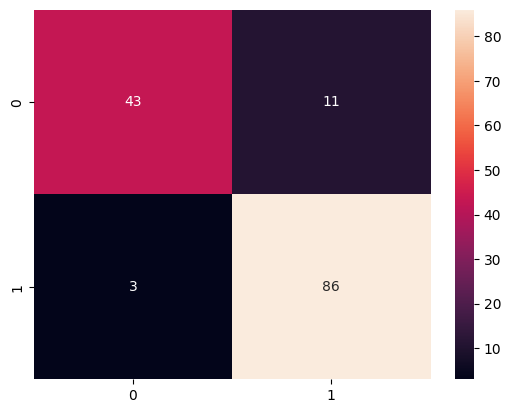

In [92]:
sns.heatmap(matriz, annot=True);